In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re

import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

print(os.listdir("../input"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['Hindi_English_Truncated_Corpus.csv']


In [2]:
lines=pd.read_csv("../input/Hindi_English_Truncated_Corpus.csv",encoding='utf-8')

In [3]:
lines['source'].value_counts()

tides        50000
ted          39881
indic2012    37726
Name: source, dtype: int64

In [4]:
lines=lines[lines['source']=='ted']

In [5]:
len(lines)

39881

In [6]:
pd.isnull(lines).sum()

source              0
english_sentence    0
hindi_sentence      0
dtype: int64

In [7]:
lines=lines[~pd.isnull(lines['english_sentence'])]

In [8]:
lines.drop_duplicates(inplace=True)

* ### Let us pick any 25000 rows from the dataset.

In [9]:
lines=lines.sample(n=25000,random_state=2048)
lines.shape

(25000, 3)

In [10]:
# Lowercase all characters
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.lower())
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.lower())

In [11]:
# Remove quotes
lines['english_sentence']=lines['english_sentence'].apply(lambda x: re.sub("'", '', x))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub("'", '', x))

In [12]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines['english_sentence']=lines['english_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [13]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.translate(remove_digits))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.translate(remove_digits))

lines['hindi_sentence'] = lines['hindi_sentence'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

# Remove extra spaces
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.strip())
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.strip())
lines['english_sentence']=lines['english_sentence'].apply(lambda x: re.sub(" +", " ", x))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub(" +", " ", x))


In [14]:
# Add start and end tokens to target sequences
lines['hindi_sentence'] = lines['hindi_sentence'].apply(lambda x : 'START_ '+ x + ' _END')

In [15]:
lines.head()

,source,english_sentence,hindi_sentence
92636,ted,kbs first time a rally and a street play in a rural school,START_ kbs पहली बार एक ग्रामीण विद्यालय में जमघट एवं नुक्कड़ नाटक _END
94543,ted,once i got here to palm springs,START_ पाम स्प्रिंग palm springs आने के बाद मुझे मिल सकता है _END
118215,ted,so the final part of the puzzle is,START_ अब आते हैं पहेली के आखिरी हिस्से पर _END
58969,ted,by just getting them to team with neighbors as you can see here,START_ सिर्फ उन्हें अपने पड़ोसियों के साथ टीम में कम करने से जैसे की आप यहाँ देख सकते हैं _END
90973,ted,had nothing to do with the rest of the world,START_ से दुनिया को कोई फर्क नहीं पड़ता _END


In [16]:
### Get English and Hindi Vocabulary
all_eng_words=set()
for eng in lines['english_sentence']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

all_hindi_words=set()
for hin in lines['hindi_sentence']:
    for word in hin.split():
        if word not in all_hindi_words:
            all_hindi_words.add(word)

In [17]:
len(all_eng_words)

13958

In [18]:
len(all_hindi_words)

17538

In [19]:
lines['length_eng_sentence']=lines['english_sentence'].apply(lambda x:len(x.split(" ")))
lines['length_hin_sentence']=lines['hindi_sentence'].apply(lambda x:len(x.split(" ")))

In [20]:
lines.head()

,source,english_sentence,hindi_sentence,length_eng_sentence,length_hin_sentence
92636,ted,kbs first time a rally and a street play in a rural school,START_ kbs पहली बार एक ग्रामीण विद्यालय में जमघट एवं नुक्कड़ नाटक _END,13,13
94543,ted,once i got here to palm springs,START_ पाम स्प्रिंग palm springs आने के बाद मुझे मिल सकता है _END,7,13
118215,ted,so the final part of the puzzle is,START_ अब आते हैं पहेली के आखिरी हिस्से पर _END,8,10
58969,ted,by just getting them to team with neighbors as you can see here,START_ सिर्फ उन्हें अपने पड़ोसियों के साथ टीम में कम करने से जैसे की आप यहाँ देख सकते हैं _END,13,20
90973,ted,had nothing to do with the rest of the world,START_ से दुनिया को कोई फर्क नहीं पड़ता _END,10,9


In [21]:
lines[lines['length_eng_sentence']>30].shape

(0, 5)

In [22]:
lines=lines[lines['length_eng_sentence']<=20]
lines=lines[lines['length_hin_sentence']<=20]

In [23]:
lines.shape

(24780, 5)

In [24]:
print("maximum length of Hindi Sentence ",max(lines['length_hin_sentence']))
print("maximum length of English Sentence ",max(lines['length_eng_sentence']))

maximum length of Hindi Sentence  20
maximum length of English Sentence  20


In [25]:
max_length_src=max(lines['length_hin_sentence'])
max_length_tar=max(lines['length_eng_sentence'])

In [26]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_hindi_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_hindi_words)
num_encoder_tokens, num_decoder_tokens

(13958, 17538)

In [27]:
num_decoder_tokens += 1 #for zero padding


In [28]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [29]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [30]:
lines = shuffle(lines)
lines.head(10)

,source,english_sentence,hindi_sentence,length_eng_sentence,length_hin_sentence
52429,ted,youve read about it already,START_ आप तो यह ख़बर पहले ही पढ़ चुके हैं _END,5,11
164,ted,like youve always got two choices,START_ कि आपके पास हमेशा दो विकल्प होने चाहिए _END,6,10
6869,ted,its sad and its not pleasant to talk about,START_ यह दर्दनाक है और इसके बारे में बात करना अच्छा नहीं लगता _END,9,14
1030,ted,but they think that one is the input to the other,START_ पर वे समझते है कि सरकार का सीधा ताल्लुक राजनीति से है _END,11,14
68799,ted,anjalis father a drunkard,START_ अंजलि के पिता एक शराबी _END,4,7
40697,ted,the hundreds of thousands,START_ हजारो लाखो _END,4,4
84398,ted,so we could just walk in the street during the next days,START_ तो अगले कुछ दिन हम सिर्फ सड़क पर टहलते रहे _END,12,12
31158,ted,is that they be about the same,START_ वे एक से रहे _END,7,6
29460,ted,included in his new marketing strategy,START_ को किस प्रकार शामिल किया जाएगा। _END,6,8
99205,ted,are there any people here under the age of,START_ क्या यहाँ वर्ष की उम्र के अंतर्गत लोग है _END,9,11


In [31]:
len(lines['hindi_sentence'])

24780

### Split the data into train and test

In [32]:
X, y = lines['english_sentence'], lines['hindi_sentence']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)
X_train.shape, X_test.shape

((19824,), (4956,))

### Let us save this data

In [33]:
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')


In [34]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

### Encoder-Decoder Architecture

In [35]:
latent_dim=300

In [36]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

Instructions for updating:
Colocations handled automatically by placer.


In [37]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [38]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [39]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    4187400     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 300)    5261700     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LS

In [40]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 100

In [41]:
z=model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)



Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
154/154 [==============================] - 70s 454ms/step - loss: 6.4222 - val_loss: 6.1207
Epoch 2/100
154/154 [==============================] - 66s 427ms/step - loss: 5.8251 - val_loss: 5.8344
Epoch 3/100
154/154 [==============================] - 66s 428ms/step - loss: 5.4689 - val_loss: 5.6153
Epoch 4/100
154/154 [==============================] - 66s 427ms/step - loss: 5.2252 - val_loss: 5.5105
Epoch 5/100
154/154 [==============================] - 66s 430ms/step - loss: 5.0148 - val_loss: 5.4299
Epoch 6/100
154/154 [==============================] - 66s 430ms/step - loss: 4.8281 - val_loss: 5.3668
Epoch 7/100
154/154 [==============================] - 70s 453ms/step - loss: 4.6513 - val_loss: 5.3205
Epoch 8/100
154/154 [==============================] - 70s 456ms/step - loss: 4.4861 - val_loss: 5.2950
Epoch 9/100
154/154 [=====================

In [42]:
model.save_weights('nmt_weights.h5')

In [43]:
z.history

{'val_loss': [6.120736360549927,
  5.83440741739775,
  5.615343081323724,
  5.5105170325229045,
  5.42989949176186,
  5.366822092156661,
  5.3205178160416455,
  5.294953070188823,
  5.262647879751105,
  5.267278759103072,
  5.264392978266666,
  5.249576505861785,
  5.25256441768847,
  5.259712420011821,
  5.27323381524337,
  5.314939549094753,
  5.337396646800794,
  5.381601572036743,
  5.400891667918155,
  5.45161445517289,
  5.470873380962171,
  5.509754206004896,
  5.536682819065295,
  5.58160672689739,
  5.636315496344316,
  5.694210968519512,
  5.733728898198981,
  5.79425301049885,
  5.830526515057213,
  5.88374820508455,
  5.948476841575221,
  6.014574364611977,
  6.045686019094367,
  6.101779322875173,
  6.125871758711965,
  6.174837388490376,
  6.225160699141653,
  6.2692506313323975,
  6.282099021108527,
  6.3514322858107715,
  6.4031065388729695,
  6.46858485121476,
  6.47919868168078,
  6.515825924120452,
  6.566042310313175,
  6.596029356906288,
  6.652466234407927,
  6.66

In [44]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)


In [45]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

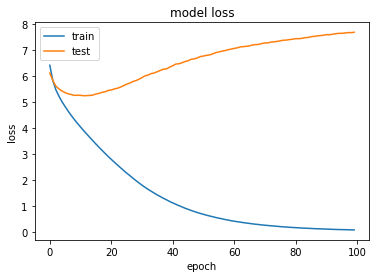

In [83]:
import matplotlib.pyplot as plt
plt.plot(z.history['loss'])
plt.plot(z.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [46]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1


In [47]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

Input English sentence: in natural resource exports
Actual Hindi Translation:  में प्रकृतिक संपदाओं का निर्यात 
Predicted Hindi Translation:  में प्रकृतिक संपदाओं का निर्यात 


In [48]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

Input English sentence: “oh what do you not understand” or “what do you do understand”
Actual Hindi Translation:  “ओह आप क्या नहीं समझ रहे हैं” या “आप क्या समझ चुके हैं” 
Predicted Hindi Translation:  कि कैसे लोग कहाँ से पूछा है की आप साइकिल नहीं कर


In [49]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

Input English sentence: so this is the context in which aravind came into existence
Actual Hindi Translation:  अरविन्द की कहानी का यही संदर्भ है 
Predicted Hindi Translation:  अरविन्द की कहानी का यही संदर्भ है 


In [50]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

Input English sentence: but they turn big public spaces like this
Actual Hindi Translation:  लेकिन वो इस तरह के बड़े और सार्वजानिक 
Predicted Hindi Translation:  लेकिन वो इस तरह के बड़े और सार्वजानिक 


In [51]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

Input English sentence: so he takes their radio talks to their boss
Actual Hindi Translation:  पाइलट ने सैनिकों का रेडियो लिया उनके साहब से बात की 
Predicted Hindi Translation:  इसलिए मैंने लोगों को सैनिकों का प्रकार के प्रका


In [59]:
test_gen = generate_batch(X_test, y_test, batch_size = 1)

In [58]:
from nltk.translate.bleu_score import sentence_bleu


In [75]:
output=[]
inputz=[]
k=0
for i in range(len(X_test)):
    (input_seq, actual_output), _ = next(test_gen)
    decoded_sentence = decode_sequence(input_seq)
    q=y_test[k:k+1].values[0][6:-4]
    K=k+1
    x=decoded_sentence[:-4]
    inputz.append(q)
    output.append(x)    

In [81]:
print(inputz[0].split())

['जहाँ', 'लोग', 'अटके', 'पडे', 'होते', 'हैं', '।']


In [82]:
bleu = 0

for i in range(len(output)):
    bleu += sentence_bleu([inputz[i].split()], output[i].split(), weights = (0.5, 0.5))

print("BLEU score is : ", bleu / len(output))

BLEU score is :  0.07247268378107925


/opt/conda/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 